# Intialize

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time


# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66,
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

'k_pivot': 0.05,
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.06    

}



Metal device set to: Apple M1 Pro


2023-02-20 09:31:45.717119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 09:31:45.717221: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Binned cluster counts

## compute class_sz slow

In [72]:
%%time

M = Class()

M.set(cosmo_params)
M.set({
    
'output' : 'sz_cluster_counts',
'mass function' :  'M500',
'has_selection_function' : 1,
'experiment' : 0,

'y_m_relation' : 0,

'use_planck_binned_proba' : 1,


'M_min' : 5e11,
'M_max' : 1e16,

'z_min' : 0.,
'z_max' : 1.,

'm_pivot_ym [Msun]' : 3e14,



'bin_z_min_cluster_counts' : 0.,
'bin_z_max_cluster_counts' : 1.,
'bin_dz_cluster_counts' : 0.1,
'bin_dlog10_snr': 0.25,

#the paramater dlny is crucial, it controls the speed of the calculation
#important to check that lnymin and lnymax are broad enough
'dlny' : 0.05,
'lnymin' : -11.,
'lnymax' : -5.,
'sigmaM_ym' : 0.173,

#case with no scatter:
#sigmaM_ym = 0.

'dlnM_cluster_count_completeness_grid' : 0.05,


'cluster_count_completeness_grid_z_cutoff_low' : 0.5,
'cluster_count_completeness_grid_z_cutoff_mid' : 1.5,
'dz_cluster_count_completeness_grid_low_z' : 5e-3,
'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
'dz_cluster_count_completeness_grid_high_z' : 1e-1,





'signal-to-noise cut-off for survey cluster completeness' : 6,


# X ray mass bias (if applicable)
'B' : 1.,




# tabulation of mass function:
'n_z_dndlnM' : 40,
'n_m_dndlnM' : 500,

# computation of mass function
# (grid in mass and redshifts for sigma and dsigma)
'ndim_masses' : 500,
'ndim_redshifts' : 40,

# pk setup for computation of sigma and dsigma
'k_per_decade_class_sz' : 20.,
'k_min_for_pk_class_sz' : 1e-3,
'k_max_for_pk_class_sz' : 1e1,
'P_k_max_h/Mpc' : 1e1,
})
M.compute()

CPU times: user 8.33 s, sys: 18.3 ms, total: 8.35 s
Wall time: 1.11 s


In [73]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']

In [74]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_with_rel = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
N_clusters_y_theory_with_rel = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))


In [75]:
N_clusters_z_theory

[228.17599725490928,
 467.28398542794577,
 409.41263126847167,
 302.98479339439865,
 208.3874594185129,
 136.08174517465235,
 84.48046208284634,
 50.23751351795535,
 28.739325136888798,
 14.627214999486574]

Text(0, 0.5, '$N$')

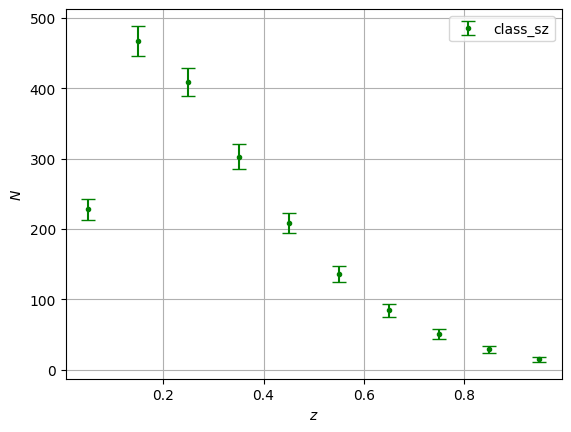

In [76]:
plt.errorbar(z_center,N_clusters_z_theory,yerr=np.sqrt(N_clusters_z_theory),marker='o',markersize=3.,ls='none',label='class_sz',capsize=5,c='green')

plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')


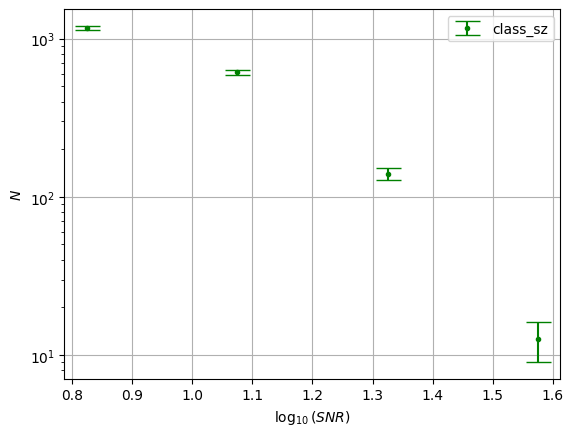

In [77]:
plt.errorbar(log10y_center,N_clusters_y_theory,yerr=np.sqrt(N_clusters_y_theory),marker='o',markersize=3.,ls='none',label='class_sz',capsize=9,c='green')
plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')


## compute class_szfast

In [90]:
%%time

M = Class()

M.set(cosmo_params)
M.set({
    
'output' : 'sz_cluster_counts',
'mass function' :  'M500',
'has_selection_function' : 1,
'experiment' : 0,

'y_m_relation' : 0,

'use_planck_binned_proba' : 1,


'M_min' : 5e11,
'M_max' : 1e16,

'z_min' : 0.,
'z_max' : 1.,

'm_pivot_ym [Msun]' : 3e14,



'bin_z_min_cluster_counts' : 0.,
'bin_z_max_cluster_counts' : 1.,
'bin_dz_cluster_counts' : 0.1,
'bin_dlog10_snr': 0.25,

#the paramater dlny is crucial, it controls the speed of the calculation
#important to check that lnymin and lnymax are broad enough
'dlny' : 0.05,
'lnymin' : -11.,
'lnymax' : -5.,
'sigmaM_ym' : 0.173,

#case with no scatter:
#sigmaM_ym = 0.

'dlnM_cluster_count_completeness_grid' : 0.05,


'cluster_count_completeness_grid_z_cutoff_low' : 0.5,
'cluster_count_completeness_grid_z_cutoff_mid' : 1.5,
'dz_cluster_count_completeness_grid_low_z' : 5e-3,
'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
'dz_cluster_count_completeness_grid_high_z' : 1e-1,





'signal-to-noise cut-off for survey cluster completeness' : 6,


# X ray mass bias (if applicable)
'B' : 1.,




# tabulation of mass function:
'n_z_dndlnM' : 40,
'n_m_dndlnM' : 500,

# computation of mass function's sigma/dsigm
# (grid in redshifts for sigma and dsigma)
'ndim_redshifts' : 40,

})
M.compute_class_szfast()

CPU times: user 1.14 s, sys: 82.8 ms, total: 1.23 s
Wall time: 475 ms


In [91]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']

In [92]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_with_rel = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
N_clusters_y_theory_with_rel = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))


In [93]:
N_clusters_z_theory

[221.29068690365636,
 447.33003672369307,
 387.56252992030073,
 283.9616390394404,
 193.62897896993624,
 125.5187090464395,
 77.34639671372304,
 45.63138469675464,
 25.89497843575253,
 13.079835891880325]

Text(0, 0.5, '$N$')

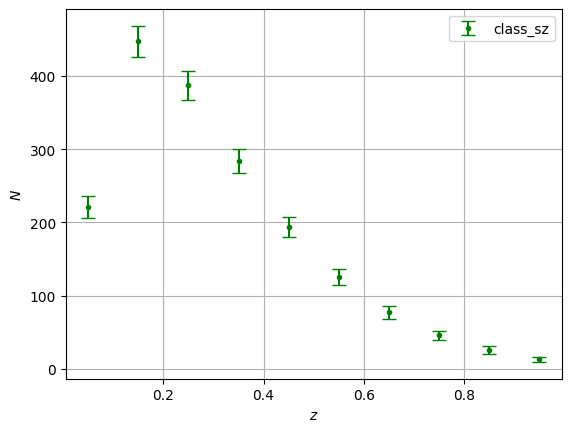

In [94]:
plt.errorbar(z_center,N_clusters_z_theory,yerr=np.sqrt(N_clusters_z_theory),marker='o',markersize=3.,ls='none',label='class_sz',capsize=5,c='green')

plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')


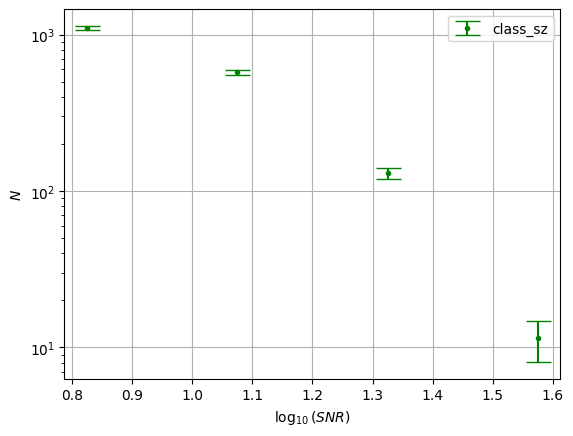

In [95]:
plt.errorbar(log10y_center,N_clusters_y_theory,yerr=np.sqrt(N_clusters_y_theory),marker='o',markersize=3.,ls='none',label='class_sz',capsize=9,c='green')
plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')


# Unbinned cluster counts

## compute class_sz slow

In [110]:
%%time

M = Class()

M.set(cosmo_params)
M.set({
          # 'non_linear': 'halofit',
          'output' : 'sz_unbinned_cluster_counts',
          'mass function' : 'M500',

          'has_selection_function' : 1,
          'experiment' : 0, # Planck
          'y_m_relation' : 0,
          'signal-to-noise cut-off for survey cluster completeness' : 6.,
          # 'use_planck_binned_proba' : 1,

          'M_min' : 5e13,
          'M_max' : 5e15,

          'z_min': 0.,
          'z_max': 1.,
          
          # # tabulation of mass function:
          'n_z_dndlnM' : 500,
          'n_m_dndlnM' : 80,
          #
          # # computation of mass function
          # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 500,
          'ndim_redshifts' : 40,
          #
          # pk setup for computation of sigma and dsigma
          'k_per_decade_class_sz' : 20.,
          'k_min_for_pk_class_sz' : 1e-3,
          'k_max_for_pk_class_sz' : 1e1,

          'P_k_max_h/Mpc' : 1e1,


})
M.compute()

CPU times: user 7.32 s, sys: 28.9 ms, total: 7.35 s
Wall time: 972 ms


In [109]:
M.szunbinned_loglike()

-1793.416278887355

## compute class_szfast

In [112]:
%%time

M = Class()

M.set(cosmo_params)
M.set({

  'output' : 'sz_unbinned_cluster_counts',
  'mass function' : 'M500',

  'has_selection_function' : 1,
  'experiment' : 0, # Planck
  'y_m_relation' : 0,
  'signal-to-noise cut-off for survey cluster completeness' : 6.,
  # 'use_planck_binned_proba' : 1,

  'M_min' : 5e13,
  'M_max' : 5e15,

  'z_min': 0.,
  'z_max': 1.,

  # # tabulation of mass function:
  'n_z_dndlnM' : 80,
  'n_m_dndlnM' : 500,
  #
  # # computation of mass function
  # # (grid in mass and redshifts for sigma and dsigma)

  'ndim_redshifts' : 40,

})
M.compute_class_szfast()

CPU times: user 342 ms, sys: 71.4 ms, total: 413 ms
Wall time: 288 ms


In [113]:
M.szunbinned_loglike()

-1690.6746632342515